In [1]:
# Don't do this. Do as I say and not as I code.
import sys
sys.path.insert(0, "../") 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from data_utils import (generate_data, test_data)
from mpl_utils import mpl_style

from model import LatentClusteringModel

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
seed = 42

J = 3     # number of latent factors
D = 10    # dimensionality of data
N = 10000 # number of data points
K = 1     # number of clusters

data_kwds = dict(N=N, D=D, J=J, K=K, seed=seed, full_output=True,
                 __cluster_mu_theta_scale=1, __cluster_sigma_theta_scale=1)
data, truths = generate_data(**data_kwds)

if len(truths["psi"].shape) == 2:
    truths["psi"] = np.diag(truths["psi"])

In [3]:
model = LatentClusteringModel(n_components=J, tol=1e-2)
model.fit(data["y"])

0 -141140.8389469144
1 -139165.62347937384
2 -138314.60244749946
3 -138001.00233241633
4 -137875.9651426397
5 -137819.90065069083
6 -137791.98617266896
7 -137776.7325618085
8 -137767.64211340144
9 -137761.75264625764
10 -137757.62357265406
11 -137754.5193413705
12 -137752.04959362693
13 -137749.99969823458
14 -137748.24701654573
15 -137746.71815312008
16 -137745.36665324433
17 -137744.16119500564
18 -137743.07926447535
19 -137742.10372535043
20 -137741.22092523146
21 -137740.41962086648
22 -137739.6903422443
23 -137739.02499444733
24 -137738.41659112496
25 -137737.85906359143
26 -137737.34711583698
27 -137736.87610943586
28 -137736.44196940938
29 -137736.0411057755
30 -137735.67034743784
31 -137735.3268860995
32 -137735.00822849158
33 -137734.71215556483
34 -137734.43668755368
35 -137734.18005400422
36 -137733.9406680076
37 -137733.71710400115
38 -137733.5080786006
39 -137733.3124340115
40 -137733.12912363646
41 -137732.957199561
42 -137732.7958016439
43 -137732.64414798454
44 -137732.

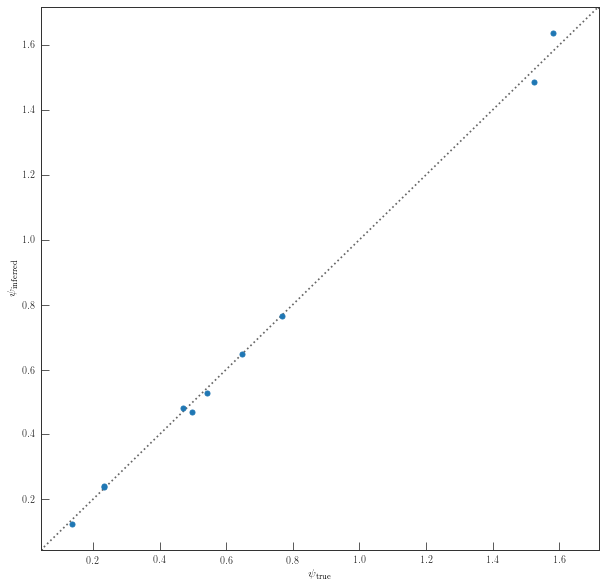

In [4]:
# psi 
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(truths["psi"], model._noise_variance)
limits = np.array([ax.get_xlim(), ax.get_ylim()])
limits = (np.min(limits), np.max(limits))
ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

ax.set_xlabel(r"$\psi_\textrm{true}$")
ax.set_ylabel(r"$\psi_\textrm{inferred}$")

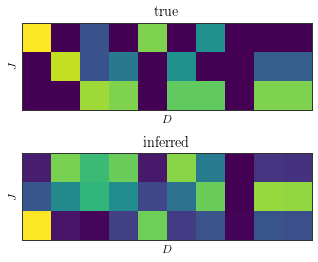

In [5]:
# The factor loads between true and inferred will not line up exactly.
# Need to infer which is which.
fig, axes = plt.subplots(2)
axes[0].imshow(np.abs(truths["L"]), interpolation="nearest")
axes[1].imshow(np.abs(model._factor_loads), interpolation="nearest")
for ax in axes:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xlabel(r"$D$")
    ax.set_ylabel(r"$J$")
    
axes[0].set_title(r"\textrm{true}")
axes[1].set_title(r"\textrm{inferred}")

In [6]:
# match-maker, match-maker, make me a match,...
# TODO: probably a clever way to do this with broadcasting
jdx = np.zeros(J, dtype=int)
for j in range(J):
    d = np.sum((np.abs(model._factor_loads) - np.abs(truths["L"][j]))**2, axis=1)
    jdx[j] = np.argmin(d)
assert len(set(jdx)) == len(jdx), "Unsure about matching"

# Apply to factor loads and scores.
model._factor_loads = model._factor_loads[jdx]
model._factor_scores = model._factor_scores.T[jdx].T

In [7]:
# Flip the signs?
signs = np.ones(J)

for j in range(J):
    x = truths["L"][j]
    y = model._factor_loads[j]
    
    A = np.vstack((np.ones(D), x)).T
    C = np.eye(D)
    cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
    b, m = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
    signs[j] = np.sign(m)

print(signs)
model._factor_loads *= signs.reshape(J, -1) 
model._factor_scores *= signs.reshape(-1, J)

[-1. -1.  1.]


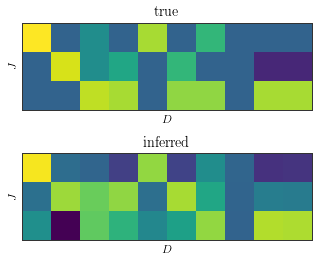

In [8]:
v = np.hstack([truths["L"], model._factor_loads]).flatten()
kwds = dict(interpolation="nearest", vmin=np.min(v), vmax=np.max(v))

fig, axes = plt.subplots(2)
axes[0].imshow(truths["L"], **kwds)
axes[1].imshow(model._factor_loads, **kwds)
for ax in axes:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xlabel(r"$D$")
    ax.set_ylabel(r"$J$")
    
axes[0].set_title(r"\textrm{true}")
axes[1].set_title(r"\textrm{inferred}")

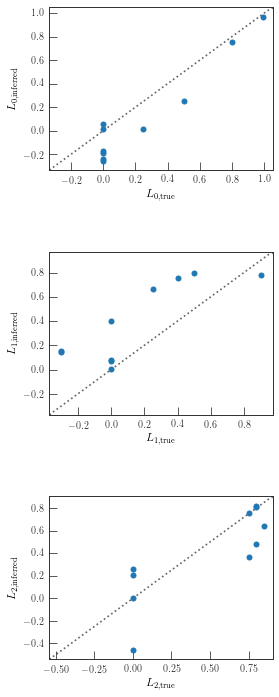

In [9]:
# Factor loads.
fig, axes = plt.subplots(J, 1, figsize=(4, 4*J))
for j, ax in enumerate(axes):
    ax.scatter(truths["L"][j], model._factor_loads[j])
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_xlabel(r"$L_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$L_{{{0},\textrm{{inferred}}}}$".format(j))

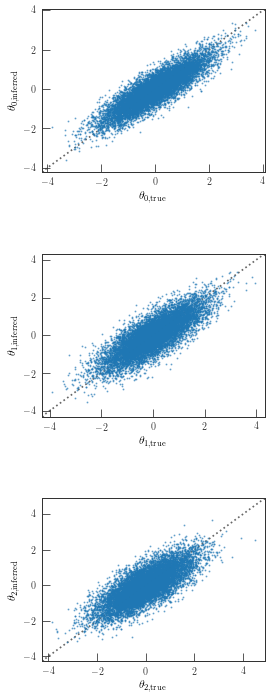

In [10]:
# Factor scores.

kwds = dict(alpha=0.5, s=1)
fig, axes = plt.subplots(J, 1, figsize=(4, 4*J))
for j, ax in enumerate(axes):
    ax.scatter(truths["theta"].T[j], model._factor_scores.T[j], **kwds)
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_xlabel(r"$\theta_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$\theta_{{{0},\textrm{{inferred}}}}$".format(j))

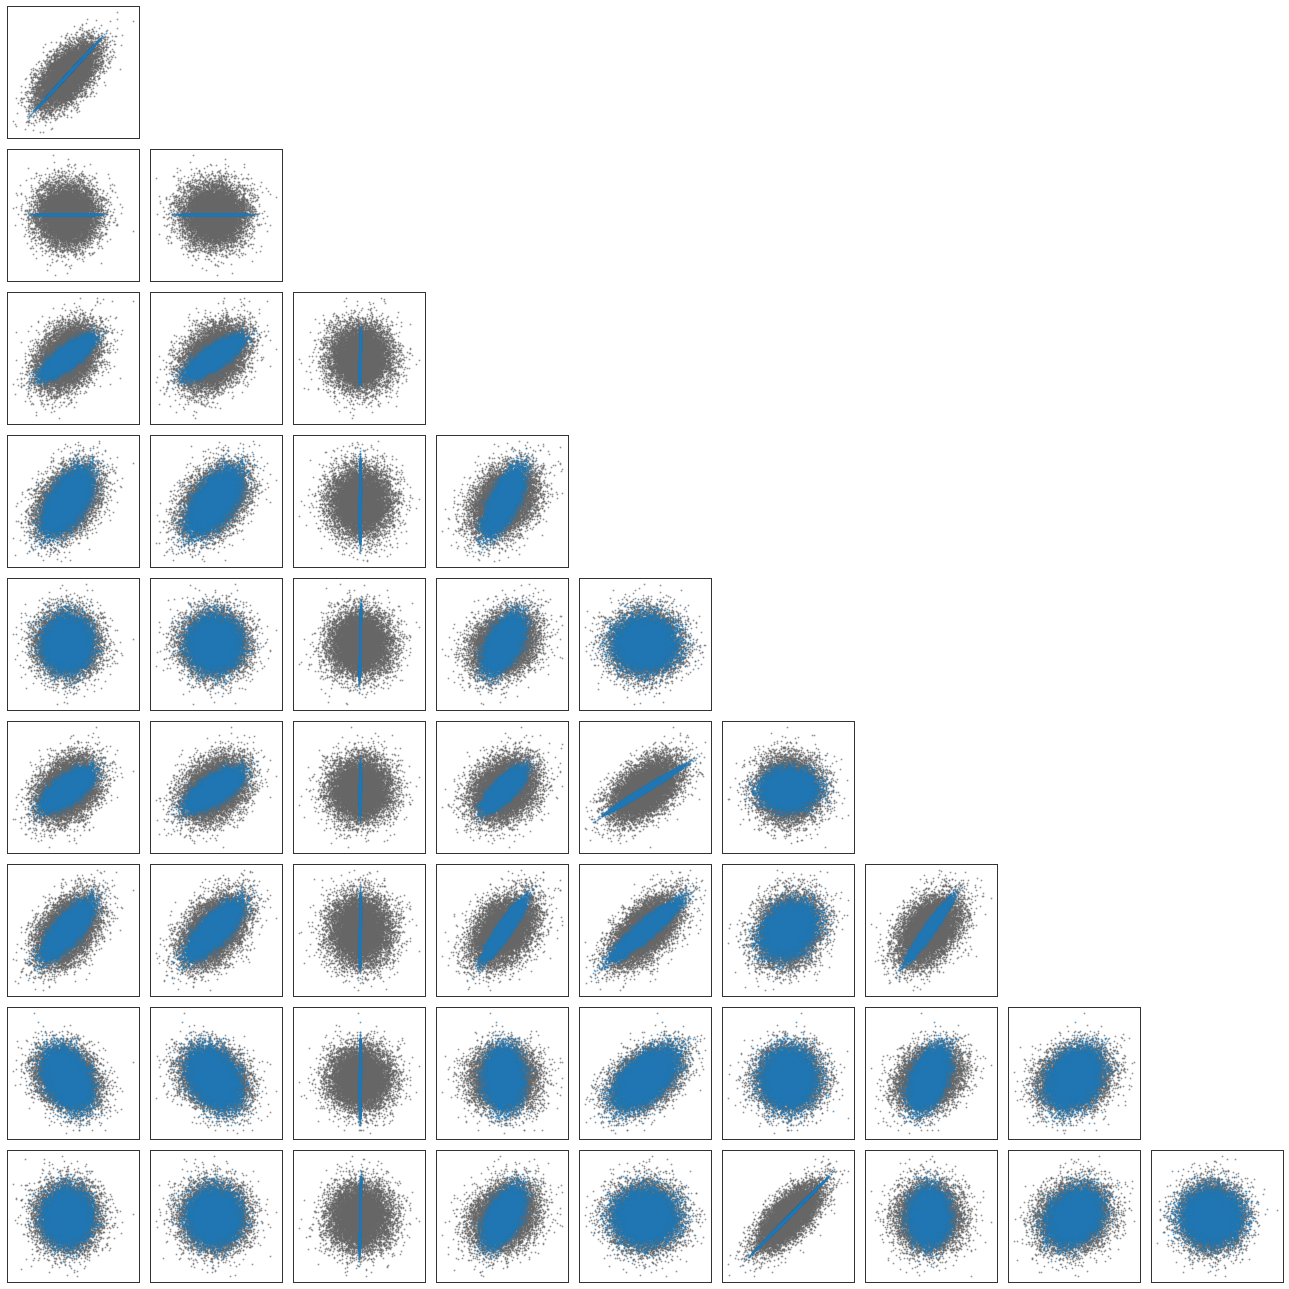

In [12]:
# Predict data?
from mpl_utils import corner_scatter_compare

y_p = np.dot(model._factor_scores, model._factor_loads) \
    + np.random.multivariate_normal(np.zeros(D), np.eye(D) * , size=N)

fig = corner_scatter_compare(data["y"], y_predicted)

(10000, 10)
(10000, 10)


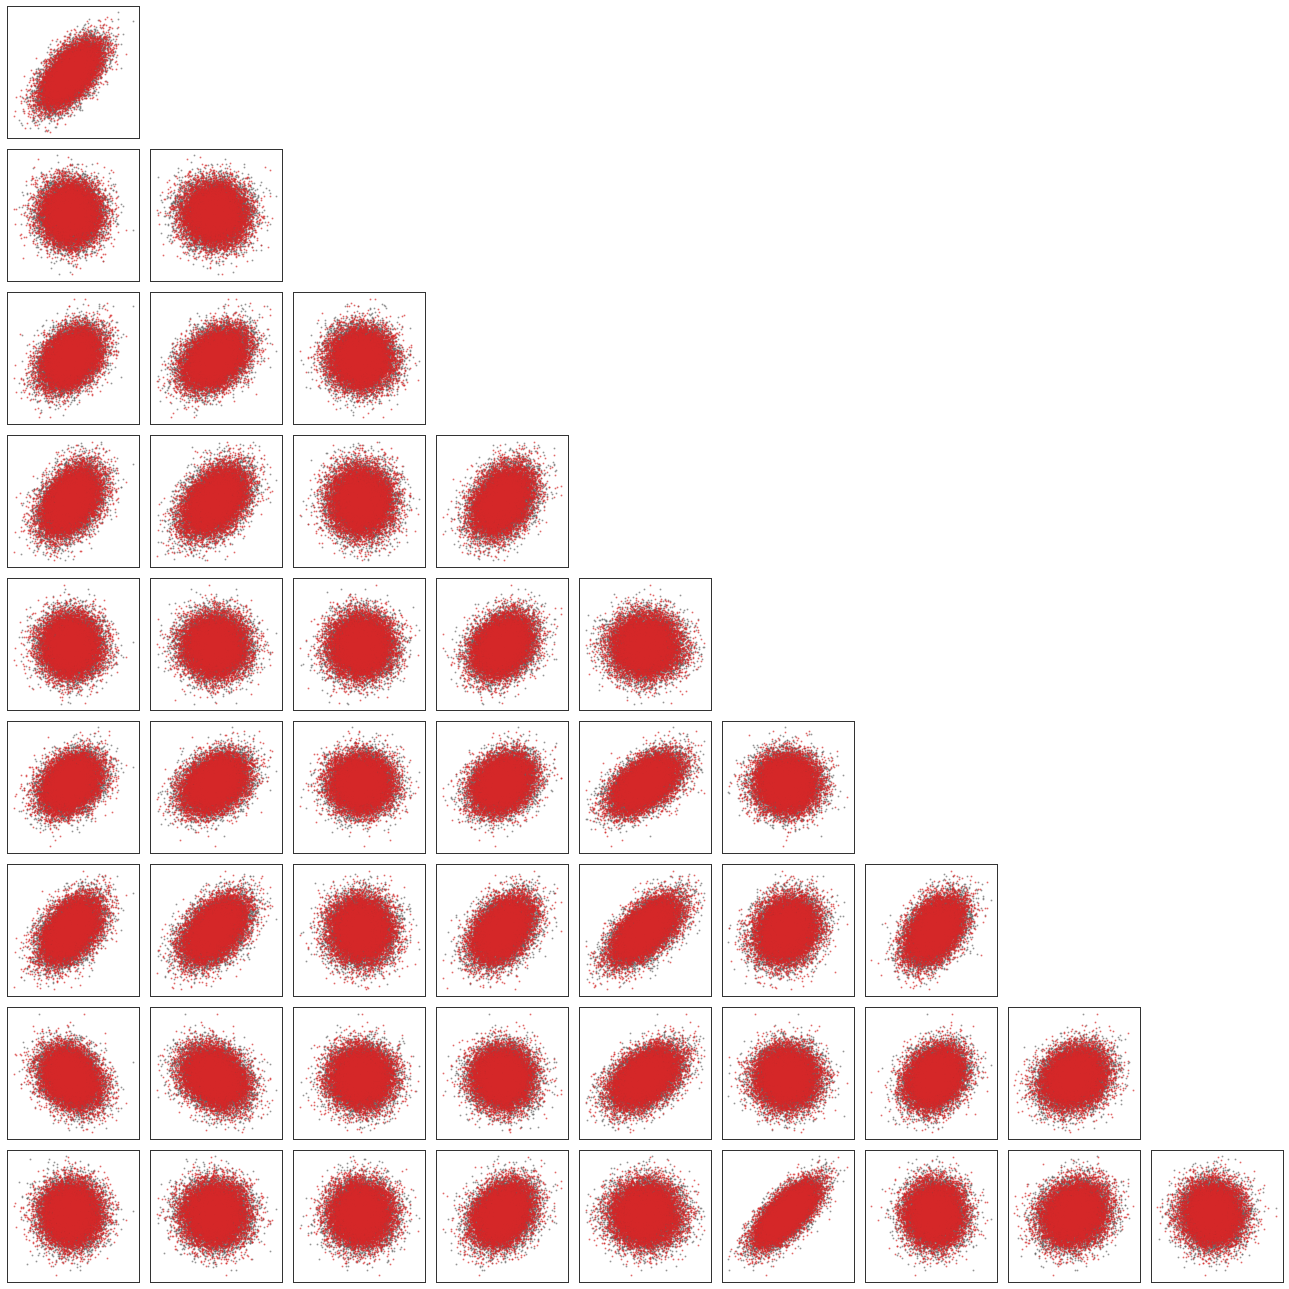

In [23]:
y_t = np.dot(truths["theta"], truths["L"]) \
    + np.random.multivariate_normal(np.zeros(D), np.eye(D) * truths["psi"], size=N)
    
fig = corner_scatter_compare(data["y"], y_t, scatter_kwds_2=dict(c="tab:red"))